In [66]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
%autoreload 2

In [68]:
import tensorflow as tf
from aml_dl.mdn.model.mdn_push_inv_model import MDNPushInverseModel

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from aml_dl.mdn.training.config import network_params_inv 

network_params['dim_input'] = 6
network_params['dim_output'] = 1
network_params['k_mixtures'] = 5
network_params['n_hidden'] = 10

In [70]:
sess = tf.Session()

network_params_inv['load_saved_model'] = False
inverse_model = MDNPushInverseModel(sess=sess, network_params=network_params_inv)



inverse_model.init_model()

## Load data

In [71]:
from aml_robot.box2d.data_manager import DataManager

In [72]:
data_manager = DataManager.from_file('../tests/data_sim_push.pkl')

In [73]:
print data_manager.get_sample(0,'push_action')

[[-0.68379618 -0.1446521   0.64955068 -0.7603183   5.4193823 ]]


In [74]:
batch_ids = data_manager.get_last_ids(5)

In [75]:
data_x = data_manager.pack_data_x(['state_start','state_end'],batch_ids)

In [76]:
print data_x

[array([ 0.        ,  0.        ,  0.        , -0.0573988 , -0.07728787,
       -2.2804687 ]), array([ 0.        ,  0.        ,  0.        , -0.07812157, -0.03132097,
       -1.50253928]), array([ 0.        ,  0.        ,  0.        , -0.02669975,  0.10277744,
       -2.19333863]), array([ 0.        ,  0.        ,  0.        , -0.07484588, -0.04326133,
        2.37050056]), array([ 0.        ,  0.        ,  0.        ,  0.05224925, -0.08353082,
       -1.74242449])]


In [77]:
data_y = data_manager.pack_data_y(batch_ids)

In [78]:
print data_y

[[3.9378579123045712], [3.4376088868797088], [1.9099644999833949], [3.5444592733419635], [5.4120737484715491]]


In [79]:
h = inverse_model.run_op('z_hidden',data_x)

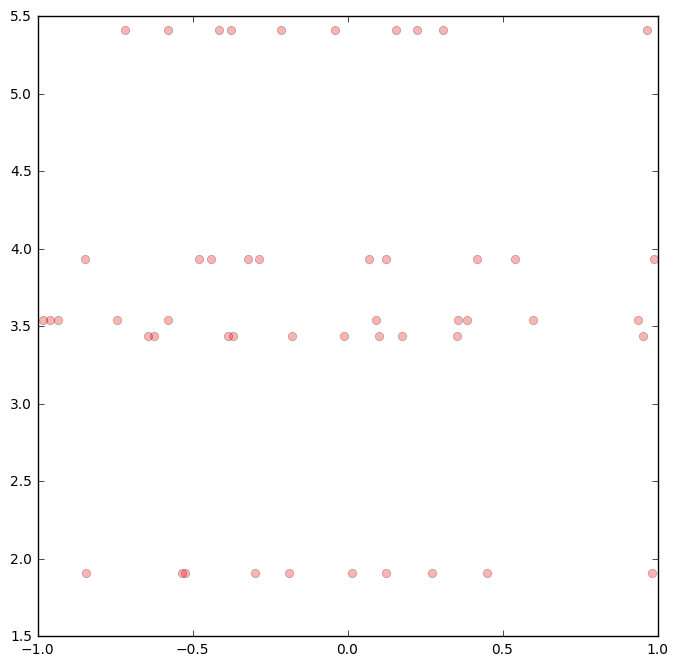

In [80]:
plt.figure(figsize=(8, 8))
plt.plot(h, data_y,'ro', alpha=0.3)
plt.show()

In [ ]:
epochs = 10000#10000

loss = inverse_model.train(data_x,data_y, epochs = epochs)


In [ ]:
# ######## SAVING MODEL #######
# save_path = saver.save(sess, "push_model.ckpt")
# print("Model saved in file: %s" % save_path)

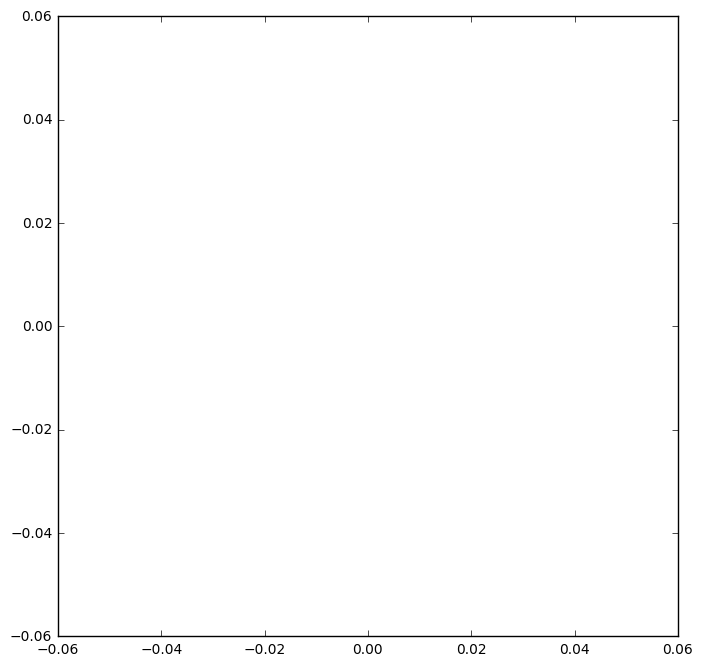

In [18]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, epochs,1), loss[100:], 'r-')
plt.show()

In [19]:
h = inverse_model.run_op('z_hidden',data_x)

In [20]:
N_SAMPLES = 1000
print N_SAMPLES
x_test = np.float32(np.random.uniform(-5.5, 5.5, (4, N_SAMPLES))).T
len(x_test)

1000


1000

In [21]:
h_test = inverse_model.run_op('z_hidden',x_test)

ValueError: Cannot feed value of shape (1000, 4) for Tensor u'x:0', which has shape '(?, 6)'

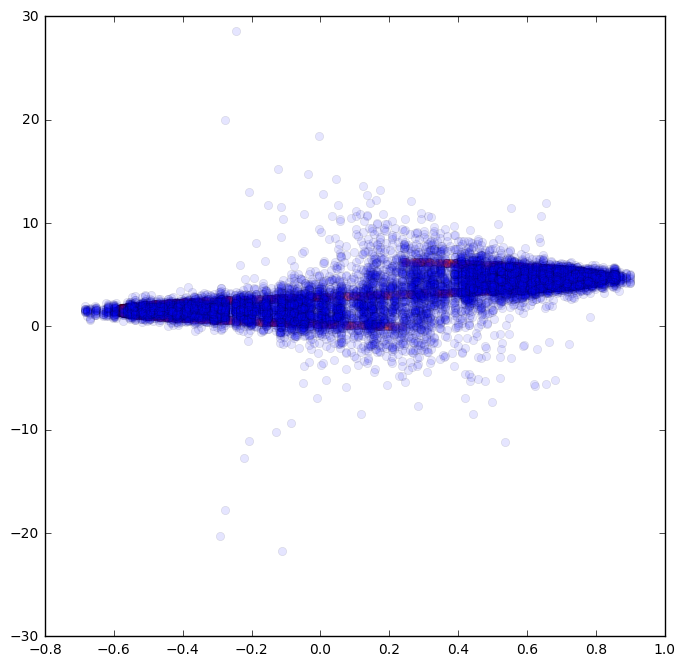

In [35]:

y_test = inverse_model.sample_out(x_test,h_test.size)
# y_test = generate_ensemble(out_pi_test, out_mu_test, out_sigma_test)

plt.figure(figsize=(8, 8))
plt.plot(h,data_y,'ro', h_test,y_test,'bo',alpha=0.1)
plt.show()

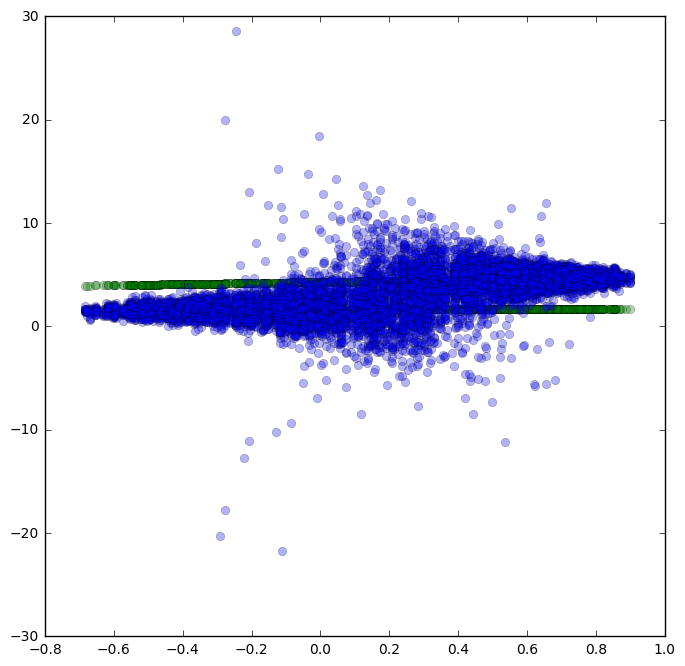

In [36]:

out_mu_test = inverse_model.run_op('mu',x_test)

plt.figure(figsize=(8, 8))
plt.plot(h_test,out_mu_test,'go', h_test,y_test,'bo',alpha=0.3)
plt.show()

In [37]:
out_pi_test = inverse_model.run_op('pi',x_test)
out_sigma_test = inverse_model.run_op('pi',x_test)
len(out_pi_test)
x_heatmap_label = np.float32(np.arange(-6,6,0.02))
y_heatmap_label = np.float32(np.arange(-6,6,0.02))

len(x_heatmap_label)

600

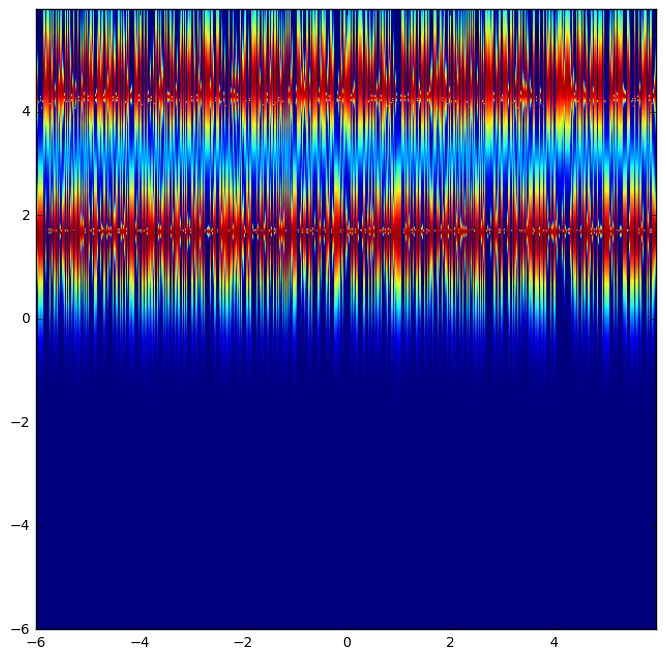

In [38]:
KMIX = 2

def custom_gaussian(x, mu, std):
  oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi)
  x_norm = (x-mu)/std
  result = oneDivSqrtTwoPI*math.exp(-x_norm*x_norm/2)/std
  return result

def generate_heatmap(out_pi, out_mu, out_sigma, x_heatmap_label, y_heatmap_label):
  N = x_heatmap_label.size
  M = y_heatmap_label.size
  K = KMIX

  z = np.zeros((N, M)) # initially random [0, 1]

  mu = 0
  std = 0
  pi = 0

  # transforms result into random ensembles
  for k in range(0, K):
    for i in range(0, M):
      pi = out_pi[i, k]
      mu = out_mu[i, k]
      std = out_sigma[i, k]
      for j in range(0, N):
        z[N-j-1, i] += pi * custom_gaussian(y_heatmap_label[j], mu, std)

  return z

def draw_heatmap(xedges, yedges, heatmap):
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  plt.figure(figsize=(8, 8))
  plt.imshow(heatmap, extent=extent)
  plt.show()

z = generate_heatmap(out_pi_test, out_mu_test, out_sigma_test, x_heatmap_label, y_heatmap_label)
draw_heatmap(x_heatmap_label, y_heatmap_label, z)